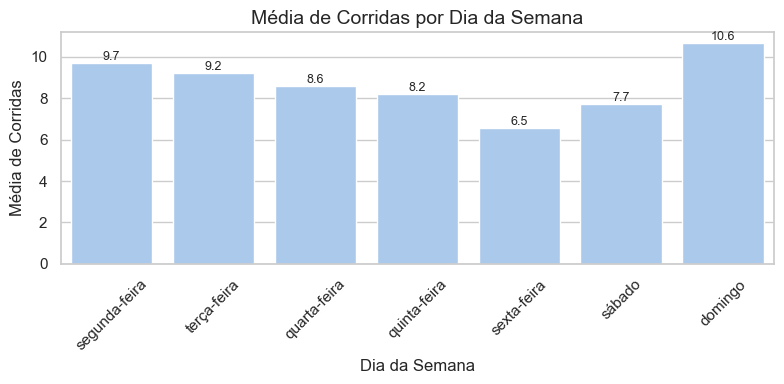

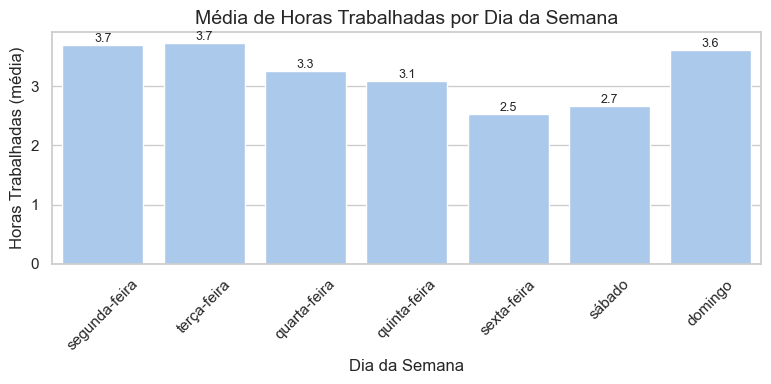

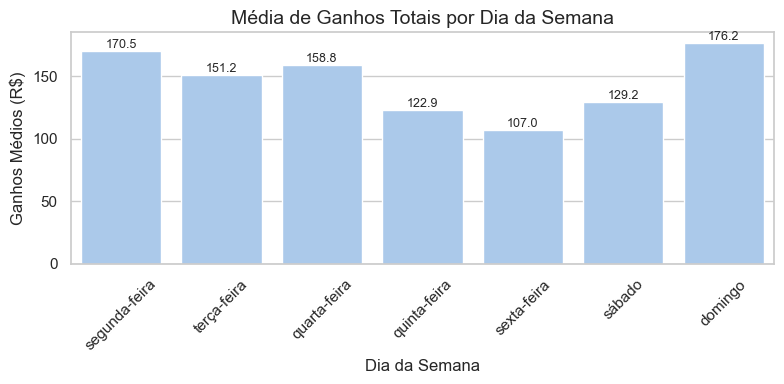

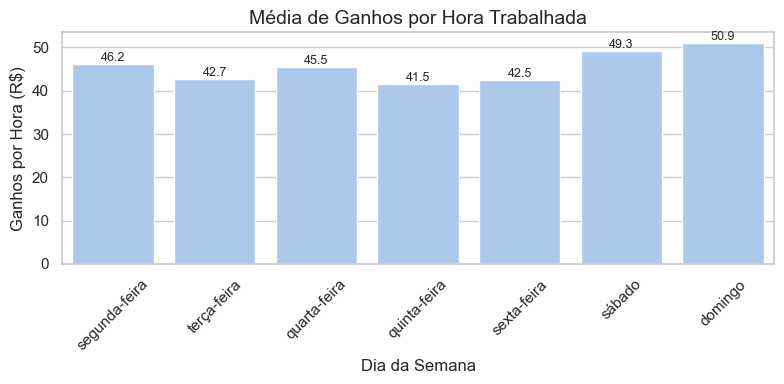

         Order ID Order status Order call PAX/Date Order call PAX/Hour  \
0  22073875050856     finished          2025-02-24     0 days 02:15:11   
1  22073895862148   unfinished          2025-02-24     0 days 07:54:07   
2  22073873137160     finished          2025-02-24     0 days 01:33:52   
3  22073894868580     finished          2025-02-24     0 days 07:39:38   
4  22073894850000   unfinished          2025-02-24     0 days 07:39:48   

  Order call PAX/Day Driver answer/Date Driver answer/Hour  \
0      segunda-feira         2025-02-24           02:15:23   
1      segunda-feira         2025-02-24           07:54:49   
2      segunda-feira         2025-02-24           01:34:55   
3      segunda-feira         2025-02-24           07:40:28   
4      segunda-feira         2025-02-24           07:40:03   

       Departure Time          Cancel Time Order complete time  \
0 2025-02-24 02:15:10                  NaN 2025-02-24 02:40:16   
1 2025-02-24 07:53:49  2025-02-24 08:05:18 2025-02

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime

# === CONFIGURAÇÕES GERAIS ===
sns.set(style="whitegrid", palette="pastel")
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# === FUNÇÕES AUXILIARES ===

def plot_bar_with_labels(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=x, y=y)
    for p in ax.patches:
        value = p.get_height()
        ax.annotate(f'{value:.1f}', 
                    (p.get_x() + p.get_width() / 2., value), 
                    ha='center', va='bottom', fontsize=9)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === CARREGAMENTO E PRÉ-PROCESSAMENTO ===

arquivo = r"C:\Users\Tiago\Desktop\Vitor Docs\99 Analitycs\motorista-data-insights\data\Dados99.xlsx"
df = pd.read_excel(arquivo, sheet_name="order_info")

# Conversões de data e hora
df["Order call PAX/Date"] = pd.to_datetime(df["Order call PAX/Date"])
df["Order call PAX/Hour"] = df["Order call PAX/Hour"].apply(
    lambda t: timedelta(hours=t.hour, minutes=t.minute, seconds=t.second) if pd.notnull(t) else pd.NaT
)
df["Order complete time"] = pd.to_datetime(df["Order complete time"], errors='coerce')
df["Departure Time"] = pd.to_datetime(df["Departure Time"], errors='coerce')

# Conversões numéricas
df["Duration_min"] = df["Order duration/Seconds"] / 60
df["Charged  Distance"] = pd.to_numeric(df["Charged  Distance"], errors='coerce')
df["Total fee"] = pd.to_numeric(df["Total fee"], errors='coerce')

# Filtro de corridas válidas
df_finalizadas = df[(df["Order status"] == "finished") & (df["Total fee"].notnull())].copy()
df_finalizadas["data"] = df_finalizadas["Order call PAX/Date"]
df_finalizadas["dia_semana"] = df_finalizadas["Order call PAX/Day"]

ordem_dias = ["segunda-feira", "terça-feira", "quarta-feira", "quinta-feira", 
              "sexta-feira", "sábado", "domingo"]

# === ANÁLISES E GRÁFICOS ===

# 1. Média de corridas por dia da semana
dias_unicos = df_finalizadas.groupby("dia_semana")["data"].nunique()
corridas_por_dia = df_finalizadas["dia_semana"].value_counts()
media_corridas = (corridas_por_dia / dias_unicos).reindex(ordem_dias)

plot_bar_with_labels(
    media_corridas.index, media_corridas.values,
    "Média de Corridas por Dia da Semana",
    "Dia da Semana", "Média de Corridas"
)

# 2. Média de horas trabalhadas por dia da semana
df_finalizadas = df_finalizadas.sort_values(by=["data", "Departure Time"])
df_finalizadas["tempo_espera"] = df_finalizadas.groupby("data")["Departure Time"].diff()
df_finalizadas["novo_periodo"] = (df_finalizadas["tempo_espera"] > timedelta(hours=1)).fillna(True).astype(int)
df_finalizadas["id_sessao"] = df_finalizadas.groupby("data")["novo_periodo"].cumsum()

sessoes = df_finalizadas.groupby(["data", "dia_semana", "id_sessao"]).agg({
    "Departure Time": "min",
    "Order complete time": "max"
}).reset_index()

sessoes["duracao_horas"] = (sessoes["Order complete time"] - sessoes["Departure Time"]).dt.total_seconds() / 3600
horas_por_dia = sessoes.groupby(["data", "dia_semana"])["duracao_horas"].sum().reset_index()
media_horas = horas_por_dia.groupby("dia_semana")["duracao_horas"].mean().reindex(ordem_dias)

plot_bar_with_labels(
    media_horas.index, media_horas.values,
    "Média de Horas Trabalhadas por Dia da Semana",
    "Dia da Semana", "Horas Trabalhadas (média)"
)

# 3. Média de ganhos totais por dia da semana
ganhos_dia = df_finalizadas.groupby(["data", "dia_semana"])["Total fee"].sum().reset_index()
ganhos_dia.columns = ["data", "dia_semana", "ganho_total_dia"]
media_ganhos = ganhos_dia.groupby("dia_semana")["ganho_total_dia"].mean().reindex(ordem_dias)

plot_bar_with_labels(
    media_ganhos.index, media_ganhos.values,
    "Média de Ganhos Totais por Dia da Semana",
    "Dia da Semana", "Ganhos Médios (R$)"
)

# 4. Média de ganhos por hora trabalhada
ganhos_horas = pd.merge(ganhos_dia, horas_por_dia, on="data")
ganhos_horas["ganho_por_hora"] = ganhos_horas["ganho_total_dia"] / ganhos_horas["duracao_horas"]
ganhos_horas["dia_semana"] = ganhos_horas["dia_semana_x"]
media_ganho_hora = ganhos_horas.groupby("dia_semana")["ganho_por_hora"].mean().reindex(ordem_dias)

plot_bar_with_labels(
    media_ganho_hora.index, media_ganho_hora.values,
    "Média de Ganhos por Hora Trabalhada",
    "Dia da Semana", "Ganhos por Hora (R$)"
)

# === DEBUG ===
print(df.head())
print(df.info())
